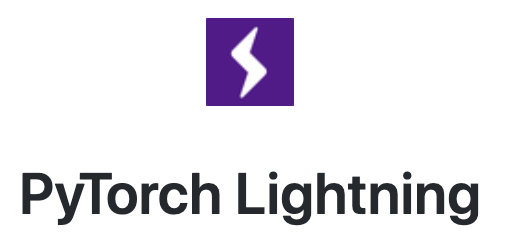

# ALBERT for Question Answering

We are using a tensor model on top of ALBERT for the SQUAD 2.0 dataset


## Setup  
First, let's check the GPU we got. If memory < 11GB, I'd suggest to do factory reset runtime. Ideally, try to get 16GB

In [1]:
!nvidia-smi

Mon Nov 30 15:09:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Installing all necessary libraries -- Pytorch Lightning, transformers and tensorflow

In [2]:
%tensorflow_version 1.x
!pip install -q pytorch-lightning
!pip install -q transformers

TensorFlow 1.x selected.
     |████████████████████████████████| 563kB 8.3MB/s 
     |████████████████████████████████| 829kB 32.6MB/s 
     |████████████████████████████████| 92kB 12.9MB/s 
     |████████████████████████████████| 10.6MB 31.6MB/s 
     |████████████████████████████████| 276kB 63.7MB/s 
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow 1.15.2 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.4.0 which is incompatible.
     |████████████████████████████████| 1.3MB 8.3MB/s 
     |████████████████████████████████| 890kB 29.6MB/s 
     |████████████████████████████████| 1.1MB 48.6MB/s 
     |████████████████████████████████| 2.9MB 68.1MB/s 


Some more importing

In [3]:
import os
import pickle, json
import torch
import numpy as np
from tqdm import tqdm, trange
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader, random_split
import pytorch_lightning as pl
from transformers import AlbertModel, AlbertTokenizer

## Data download 

Mount the drive to get access to reading and writing files

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'ybshmmlchk/'

Mounted at /content/gdrive


#### Loading preprocessed data. For the preprocessing part -- see Albert_Preprocessing.ipynb


Define your configuration -- bert model version and max_len

In [5]:
conf = {
    'model': 'albert', ## options for now-- albert, bert
    'model_version' : 'base-v2',
    'max_len' : 256
}

In [6]:
#returns tokenizer and model from configuration
def nlp_model_tokenizer(conf):
  if conf['model'] == 'albert':
    from transformers import AlbertTokenizer as your_tokenizer, AlbertModel as your_nlp_model
  elif conf['model'] == 'bert':
    from transformers import BertTokenizer as your_tokenizer, BertModel as your_nlp_model
  else:
    print('Please select a different model or rewrite the code for this function to add your model')
    return False
  try:
    return your_tokenizer.from_pretrained(conf['model'] + '-' + conf['model_version']), your_nlp_model.from_pretrained(conf['model'] + '-' + conf['model_version'])
  except:
    print('Wrong model version. Please select a valid one')
    return False

tokenizer, bert = nlp_model_tokenizer(conf)

In [7]:
# load train dataset
pickle_prefix = conf['model'] + '-' + conf['model_version'] + '-' + str(conf['max_len'])
try:
  with open(root_dir + 'ybshmmlchk/' + pickle_prefix + '-train.pickle', 'rb') as f:
      train_data = pickle.load(f)
except:
  print('Training data hasnt been processed with your choice of model yet. Please go to preprocessing notebook first and run it with your configuration')  
input_ids = train_data["input_ids"]
token_type_ids = train_data["token_type_ids"]
labels = train_data["labels"]
attention_mask = train_data["attention_mask"]
answer_mask = train_data['answer_mask']
plausible_answer_mask = train_data['plausible_answer_mask']
actual_answers = train_data['actual_answers']
plausible_answers = train_data['plausible_answers']
answer_starts = train_data['answer_starts']
answer_ends = train_data['answer_ends']
full_questions = train_data['full_questions']
full_paragraphs = train_data['full_paragraphs']
indexing = list(range(0, len(labels)))
print('Number of train input ids:'.ljust(30), len(input_ids))
# print('Number of train token type ids:'.ljust(30), len(token_type_ids))
# print('Number of train labels:'.ljust(30), len(labels))

Number of train input ids:     111281


In [8]:
# load val dataset
pickle_prefix = conf['model'] + '-' + conf['model_version'] + '-' + str(conf['max_len'])
try:
  with open(root_dir + 'ybshmmlchk/' + pickle_prefix + '-val.pickle', 'rb') as f:
      val_data = pickle.load(f)
except:
  print('Training data hasnt been processed with your choice of model yet. Please go to preprocessing notebook first and run it with your configuration') 
    
val_input_ids = val_data["input_ids"]
val_token_type_ids = val_data["token_type_ids"]
val_labels = val_data["labels"]
val_attention_mask = val_data["attention_mask"]
val_answer_mask = val_data['answer_mask']
val_plausible_answer_mask = val_data['plausible_answer_mask']
val_actual_answers = val_data['actual_answers']
val_plausible_answers = val_data['plausible_answers']
val_answer_starts = val_data['answer_starts']
val_answer_ends = val_data['answer_ends']
val_full_questions = val_data['full_questions']
val_full_paragraphs = val_data['full_paragraphs']
val_indexing = list(range(0, len(val_labels)))
print('Number of val input ids:'.ljust(30), len(val_input_ids))

Number of val input ids:       5296


The fraction of unanswerable questions is about 33%, so about 66% have an answer. The average number of tokens that are in the answer is about 1%. Since the length of our "sentences" is 256, the average length of answers is about 3 tokens.

In [10]:
print('Fraction of unaswerable questions:', np.mean(labels))
print('Average fraction of answer tokens in paragraph:',np.array([np.array(x).mean() for x in answer_mask]).mean())

Fraction of unaswerable questions: 0.3361939594360223
Average fraction of answer tokens in paragraph: 0.011225874700083573


Here is an example of an entry in the dataset. Note that label is is_unanswerable, so True means there is no answer.

In [13]:
i = 153
print('Input id:', i)
print('Question:', full_questions[i])
print('Paragraph:', full_paragraphs[i])
print('Answer:', actual_answers[i])
print('Plausible answer (if answer doesnt exist):', plausible_answers[i])
print('Label:', labels[i]) 

Input id: 153
Question: What did the UN Peacebuliding Commission decide on Jan 8, 2008?
Paragraph: In 2006, due to ongoing violence, over 50,000 people in the country's northwest were at risk of starvation but this was averted due to assistance from the United Nations.[citation needed] On 8 January 2008, the UN Secretary-General Ban Ki-Moon declared that the Central African Republic was eligible to receive assistance from the Peacebuilding Fund. Three priority areas were identified: first, the reform of the security sector; second, the promotion of good governance and the rule of law; and third, the revitalization of communities affected by conflicts. On 12 June 2008, the Central African Republic requested assistance from the UN Peacebuilding Commission, which was set up in 2005 to help countries emerging from conflict avoid devolving back into war or chaos.
Answer: no answer
Plausible answer (if answer doesnt exist): the Central African Republic was eligible to receive assistance from

Now we define a function which will return train and validation dataloaders. The breakdown is 95-5.

In [9]:
def generate_squad_dataloaders(batch_size):
  # ----------------------
  # TRAIN/VAL/TEST DATALOADERS
  # ----------------------

  # TensorDataset from training examples. ".cuda()" puts the corresponding tensor on gpu
  squad_train_dataset = TensorDataset(torch.tensor(input_ids, dtype=torch.long).cuda(),
                                torch.tensor(attention_mask, dtype=torch.long).cuda(),  
                                torch.tensor(token_type_ids, dtype=torch.long).cuda(), 
                                1 - torch.tensor(labels, dtype=torch.long).cuda(), #label is 0 if there is an answer in the original dataset
                                torch.tensor(answer_mask, dtype=torch.long).cuda(),
                                torch.tensor(indexing, dtype=torch.long).cuda(),
                                torch.tensor(answer_starts).cuda(),
                                torch.tensor(answer_ends).cuda())
  
  squad_val_dataset = TensorDataset(torch.tensor(val_input_ids, dtype=torch.long).cuda(),
                                torch.tensor(val_attention_mask, dtype=torch.long).cuda(),  
                                torch.tensor(val_token_type_ids, dtype=torch.long).cuda(), 
                                1 - torch.tensor(val_labels, dtype=torch.long).cuda(), #label is 0 if there is an answer in the original dataset
                                torch.tensor(val_answer_mask, dtype=torch.long).cuda(),
                                torch.tensor(val_indexing, dtype=torch.long).cuda(),
                                torch.tensor(val_answer_starts).cuda(),
                                torch.tensor(val_answer_ends).cuda())
  
  # test is not actually used yet
  """squad_test_dataset = TensorDataset(torch.tensor(input_ids[nb_train_samples+nb_val_samples:], dtype=torch.long).cuda(),
                                torch.tensor(attention_mask[nb_train_samples+nb_val_samples:], dtype=torch.long).cuda(),  
                                torch.tensor(token_type_ids[nb_train_samples+nb_val_samples:], dtype=torch.long).cuda(), 
                                1 - torch.tensor(labels[nb_train_samples+nb_val_samples:], dtype=torch.long).cuda(), #label is 0 if there is an answer in the original dataset
                                torch.tensor(answer_mask[nb_train_samples+nb_val_samples:], dtype=torch.long).cuda(),
                                torch.tensor(indexing[nb_train_samples+nb_val_samples:], dtype=torch.long).cuda())"""

  print('Train set size:', len(labels))
  print('Validation set size:', len(val_labels))

  # train loader
  train_sampler = RandomSampler(squad_train_dataset)
  squad_train_dataloader = DataLoader(squad_train_dataset, sampler = train_sampler, batch_size = batch_size)

  # val loader
  val_sampler = SequentialSampler(squad_val_dataset)
  squad_val_dataloader = DataLoader(squad_val_dataset, sampler = val_sampler, batch_size = batch_size, shuffle = False)

  # test loader
  #test_sampler = RandomSampler(squad_test_dataset)
  #squad_test_dataloader = DataLoader(squad_test_dataset, sampler=test_sampler, batch_size = batch_size)
 
  return squad_train_dataloader, squad_val_dataloader#, squad_test_dataloader

Defining the model from BERT paper with start and end vector

In [10]:
## TODO: imports up
import torch.nn.functional as F
import pytorch_lightning as pl
from torch import nn

'''
a -- question cls
b -- paragraph cls
t -- number of bilinear products
'''

class SQUADBERTY(pl.LightningModule):

    def __init__(self, proj_dim, num_inner_products, batch_size, weight =2., answer_punishment_coeff=1.):
        super(SQUADBERTY, self).__init__() 
        self.bert = bert.cuda()
        self.bert_dim = bert.config.hidden_size #768
        self.weight = weight
        self.answer_punishment_coeff = answer_punishment_coeff
        self.batch_size = batch_size
        self.max_len = 256
        self.proj_dim = proj_dim

        self.Proj = nn.Linear(self.bert_dim, self.proj_dim)
        self.Proj_cls = nn.Linear(self.bert_dim, self.proj_dim)
        self.BL = nn.Bilinear(self.proj_dim, self.proj_dim, num_inner_products) # l scalar products of 2 vectors of dim d
        self.L = nn.Linear(num_inner_products, 2)
        self.CLS = nn.Linear(self.bert_dim, 2) #(a,b) e^a/(e^a+e^b)

        self.squad_train_dataloader, self.squad_val_dataloader = generate_squad_dataloaders(batch_size)

    def my_forward_pass(self, cls_bert_output, bert_output_full):
        current_batch_size = bert_output_full.shape[0]
        bert_output_full = torch.reshape(bert_output_full, (current_batch_size * self.max_len, self.bert_dim))
        proj_output_full = self.Proj(bert_output_full)
        proj_cls = self.Proj_cls(cls_bert_output)
        proj_cls = torch.cat([proj_cls]*self.max_len) # replicated proj_cls to make it the same shape as proj_output_full
        long_logits = self.BL(proj_cls, proj_output_full)
        long_logits = nn.ReLU6()(long_logits)
        long_logits = self.L(long_logits)
        long_logits = torch.reshape(long_logits, (current_batch_size, self.max_len, 2))
        return long_logits

    def forward(self, input_ids, attention_mask, token_type_ids):
      
        bert_output_full, cls_pooler_output = self.bert(input_ids=input_ids, 
                         attention_mask=attention_mask, 
                         token_type_ids=token_type_ids)
        # bert_output_full.shape = (batch_size, max_len, bert_dim) -- one vector of dim=bert_dim for each token
        # cls_pooler_output of shape (batch_size, bert_dim) -- Last layer hidden-state of the first token of the sequence (classification token) 
        # further processed by a Linear layer and a Tanh activation function. 
        # The Linear layer weights are trained from the next sentence prediction (classification) objective during pretraining.

        cls_bert_output = bert_output_full[:, 0, :] # vector corresponding to CLS token

        # long_logits will have shape (batch_size, max_len, 2)
        # each output of bert is projected to smaller dimension, then take a few inner products with projection of the cls vector,
        # then another dense layer to get logits
        long_logits = self.my_forward_pass(cls_bert_output, bert_output_full)
        cls_logits = self.CLS(cls_pooler_output)

        return cls_logits, long_logits

    def training_step(self, batch, batch_nb):
        # batch
        input_ids, attention_mask, token_type_ids, label, answer_mask, indexing, answer_starts, answer_ends = batch
         
        # fwd
        cls_logits, long_logits = self.forward(input_ids, attention_mask, token_type_ids)
        
        # loss
        # loss for not guessing if there is an answer
        loss1 = F.cross_entropy(cls_logits, label, weight = torch.Tensor([2.,1.]))

        # loss for each individual word -- is it in the answer?
        # TODO: need to insert weight -- around 90 bc of mismatch of 0s and 1s -- only 1% are 1s
        loss2 = F.cross_entropy(torch.reshape(long_logits, (long_logits.shape[0] * long_logits.shape[1], long_logits.shape[2])), 
                                torch.reshape(answer_mask, (answer_mask.shape[0] * answer_mask.shape[1],)), weight = torch.Tensor([1.,50.]))
        # total loss
        # TODO: experiment with punishment coeff
        loss = self.answer_punishment_coeff*loss1 + loss2
        self.log('loss', loss, prog_bar=True)
        # logs
        tensorboard_logs = {'train_loss': loss}

        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        # batch
        input_ids, attention_mask, token_type_ids, label, answer_mask, indexing, answer_starts, answer_ends = batch
         
        # fwd
        cls_logits, long_logits = self.forward(input_ids, attention_mask, token_type_ids)
        
        # loss
        # loss for not guessing if there is an answer
        loss1 = F.cross_entropy(cls_logits, label, weight = torch.Tensor([2.,1.]))

        # loss for each individual word -- is it in the answer?
        # TODO: need to insert weight -- around 90 bc of mismatch of 0s and 1s -- only 1% are 1s
        loss2 = F.cross_entropy(torch.reshape(long_logits, (long_logits.shape[0] * long_logits.shape[1], long_logits.shape[2])), 
                                torch.reshape(answer_mask, (answer_mask.shape[0] * answer_mask.shape[1],)))#, weight = torch.Tensor([1.,self.weight]))
        # total loss
        # TODO: experiment with punishment coeff
        loss = self.answer_punishment_coeff*loss1 + loss2

        # compute accuracy 
        # TODO: compute precision/recall on individual words, accuracy of start, end, exact match

        # ну хоть одна переменная должна нормально называться
        a, y1 = torch.max(cls_logits, dim=1)
        label_acc = torch.sum(y1 == label) / label.shape[0]
        self.log('label_acc', label_acc, prog_bar=True)

        return {'val_loss' : loss, 'label_acc' : label_acc}
        
    def dics_average(self, dics, name):
        d = dict()
        for key in dics[0].keys():
          d[name + key] = torch.stack([x[key] for x in dics]).mean()
        return d
    
    def validation_end(self, outputs):
        #'found_pos' : found_pos, 'pos_val' : pos_val, 'pos_res' : pos_res
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()

        """pre_dics = [x['pre_guess'] for x in outputs]
        post_dics = [x['post_guess'] for x in outputs]
        pre_d = self.dics_average(pre_dics, 'pre_avg_')
        post_d = self.dics_average(post_dics, 'post_avg_')
        #print('\n validation5 \n')
        tensorboard_logs = {'val_loss': avg_loss, 'pre_guess': pre_d, 'smart_guess': post_d}
        #print('\n validation6 \n')"""
        self.log('validation_loss', avg_loss, prog_bar=True)
        #self.log('pre', pre_d, prog_bar=True)
        label_acc = torch.stack([x['label_acc'] for x in outputs]).mean()
        self.log('val_label_acc', label_acc, prog_bar=True)
        #self.log('end_accuracy', end_acc, prog_bar=True)
        tensorboard_logs = {'val_loss': avg_loss, 'val_label_acc' : label_acc}
        return {'avg_val_loss': avg_loss, 'progress_bar': tensorboard_logs}

    '''
    def test_step(self, batch, batch_nb):
        input_ids, attention_mask, token_type_ids, label = batch
        
        y_hat, attn = self.forward(input_ids, attention_mask, token_type_ids)
        
        a, y_hat = torch.max(y_hat, dim=1)
        test_acc = accuracy_score(y_hat.cpu(), label.cpu())
        
        return {'test_acc': torch.tensor(test_acc)}

    def test_end(self, outputs):

        avg_test_acc = torch.stack([x['test_acc'] for x in outputs]).mean()

        tensorboard_logs = {'avg_test_acc': avg_test_acc}
        return {'avg_test_acc': avg_test_acc, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}
    '''
    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=5e-06, eps=1e-08)

    def train_dataloader(self):
        return self.squad_train_dataloader

    def val_dataloader(self):
        return self.squad_val_dataloader


### Trainer
The trainer takes care of putting things in the correct GPU or not.
It handles all the engineering for you (such as automatic early stopping) so you just have to worry about the model and data!

In [19]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath=base_dir + '/saved_models/tensor_model_v1',
    save_top_k=2,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory /content/gdrive/My Drive/ybshmmlchk/saved_models exists and is not empty. With save_top_k=2, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


In [20]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
model = SQUADBERTY(20, 5, 16)
# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(gpus=1, amp_level='O2',precision=16, max_epochs = 2, val_check_interval=0.25, checkpoint_callback=checkpoint_callback)#, accelerator='ddp')#, progress_bar_refresh_rate = 20)#, val_check_interval=0.25)#checkpoint_callback=checkpoint_callback, max_nb_epochs = 2val_check_interval=1,)    
trainer.fit(model) 

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name     | Type        | Params
-----------------------------------------
0 | bert     | AlbertModel | 11.7 M
1 | Proj     | Linear      | 15.4 K
2 | Proj_cls | Linear      | 15.4 K
3 | BL       | Bilinear    | 2.0 K 
4 | L        | Linear      | 12    
5 | CLS      | Linear      | 1.5 K 


Train set size: 111281
Validation set size: 5296


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)


Epoch 0: val_loss reached 0.60592 (best 0.60592), saving model to /content/gdrive/My Drive/ybshmmlchk/saved_models/tensor_model_v1-v3.ckpt as top 2


Epoch 0: val_loss reached 0.44254 (best 0.44254), saving model to /content/gdrive/My Drive/ybshmmlchk/saved_models/tensor_model_v1-v4.ckpt as top 2


Epoch 0: val_loss reached 0.37111 (best 0.37111), saving model to /content/gdrive/My Drive/ybshmmlchk/saved_models/tensor_model_v1-v5.ckpt as top 2


Epoch 0: val_loss was not in top 2


Epoch 1: val_loss was not in top 2


Epoch 1: val_loss was not in top 2


Epoch 1: val_loss was not in top 2


Epoch 1: val_loss was not in top 2


1

**Saving**

In [21]:
model_name = 'tensor_model_v1_final'
trainer.save_checkpoint(base_dir + 'saved_models/' + model_name)

**Loading**

In [11]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
model = SQUADBERTY(20, 5, 16)
model_name = 'tensor_model_v1_final'
checkpoint = torch.load(base_dir + 'saved_models/' + model_name, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

Train set size: 111281
Validation set size: 5296


SQUADBERTY(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
           

**Results on validation/train**

Helper functions

In [12]:
#returns "probabilities" of start and end. not actually probabilities, because this is before softmax
def predict(model, batch):
  input_ids, attention_mask, token_type_ids, label, answer_mask, indexing, answer_starts, answer_ends = batch
  with torch.no_grad():
    res =  model(input_ids, attention_mask, token_type_ids)
  return res

# returns start and end vectors, just based on argmax taken individually
def convert_predictions(l1, l2):#, label, answer_mask):
  a, y1 = torch.max(l1, dim=1)
  a, y2 = torch.max(l2, dim=1)
  
  return y1, y2#, guess1, guess2, d_pre, d_post

# returns start and end vectors taking into account that end>=start + start can't be before question end
def convert_predictions_improved(l1, l2, min_start):
  starts, ends = [], []
  for i in range(l1.shape[0]):
    p1, p2 = l1[i], l2[i]
    highest_prob = p1[0] + p2[0]
    start, end = 0, 0
    for k in range(min_start[i], 256):
      for j in range(k, 256):
        if p1[k] + p2[j] > highest_prob:
          highest_prob, start, end = p1[k] + p2[j], k, j
    starts.append(start)
    ends.append(end)
  return torch.Tensor(starts), torch.Tensor(ends)

def npf(tt):
  return tt.detach().cpu().numpy()

def convert_predictions_improved_v3(start_batch, end_batch, min_start=None):
  start_batch, end_batch, min_start = npf(start_batch), npf(end_batch), npf(min_start)
  #start_batch, end_batch = npf(start_batch), npf(end_batch)
  batch_size, max_len = start_batch.shape
  probs = start_batch.reshape(-1,max_len,1) + end_batch.reshape(-1,1,max_len) # array of shape: (batch_size, max_len, max_len), matrix of pairwise sums per each element of the batch
  if min_start is not None:
    mask = np.zeros(probs.shape)  # create a mask to avoid including cases where i > j or i > min_start or j > min_start
    for i,s in enumerate(min_start):
        mask[i,:s,:] = 1
        mask[i,:,:s] = 1
        mask[i][np.tril_indices(max_len,-1)] = 1
    mask[:,0,0] = 0               # we however leave i=j=0 to detect questions without answers
    probs = np.ma.array(probs,mask=mask)
    probs = np.ma.filled(probs,-np.inf)
  else:
    probs = np.triu(probs)
  max_probs = np.argmax(probs.reshape(batch_size,-1), axis=-1) # array of shape: (batch_size,), argmaxes of flattened matrices of pairwise sums
  starts, ends = np.unravel_index(max_probs, (max_len, max_len)) # two arrays of shape: (batch_size,), 'unflattenning' of max_probs
  return starts, ends

Validation itself

In [13]:
from pprint import pprint
def validate(model, s = 'val'):
  #iterator 
  if s == 'train':
    a = (model.train_dataloader())
  else:
    a = (model.val_dataloader())
  #batch = True
  d = {
        'num_examples' : 0,
        'num_labels_guessed' : 0,
        'num_ends_guessed' : 0,
        'num_exact_matches_guessed' : 0,
        'num_starts_guessed_post' : 0,
        'num_ends_guessed_post' : 0,
        'num_exact_matches_guessed_post' : 0
      }
  for batch_ndx, batch in enumerate(a):
    #batch = iterator.next()
    l1, l2 = predict(model, batch)
    a, y1 = torch.max(l1, dim=1)
    #y1, y2 = convert_predictions(l1, l2)
    input_ids, attention_mask, token_type_ids, label, answer_mask, indexing, answer_starts, answer_ends = batch
    #start, end = answer_starts, answer_ends#get_start_end(answer_mask)
    d['num_examples'] += l1.shape[0]
    d['num_labels_guessed'] += torch.sum(y1==label)
    """d['num_ends_guessed'] += torch.sum(end==y2)
    d['num_exact_matches_guessed'] += torch.sum(((start==y1).double()  + (end==y2).double() )==2.)
    _ , min_start = torch.max(token_type_ids, dim=1)
    
    y1, y2 = convert_predictions_improved_v3(l1, l2, min_start)
    #input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch
    start, end = npf(start), npf(end)
    d['num_starts_guessed_post'] += np.sum(start==y1)
    d['num_ends_guessed_post'] += np.sum(end==y2)
    d['num_exact_matches_guessed_post'] += np.sum(((start==y1).astype(int)  + (end==y2).astype(int) )==2)

    d['EM'] = d['num_exact_matches_guessed'] / d['num_examples']
    d['EM post'] = d['num_exact_matches_guessed_post'] / d['num_examples']
    if batch_ndx%300 == 0:
      print(batch_ndx)
      pprint(d)"""
  return d


In [14]:
validate(model, 'val')

{'num_ends_guessed': 0,
 'num_ends_guessed_post': 0,
 'num_exact_matches_guessed': 0,
 'num_exact_matches_guessed_post': 0,
 'num_examples': 5296,
 'num_labels_guessed': tensor(4602),
 'num_starts_guessed_post': 0}

In [27]:
4602/5296

0.8689577039274925

In [13]:
# should run this only if very interested -- takes a while
#validate(model, 'train')

{'num_ends_guessed': 0,
 'num_ends_guessed_post': 0,
 'num_exact_matches_guessed': 0,
 'num_exact_matches_guessed_post': 0,
 'num_examples': 111281,
 'num_labels_guessed': tensor(105663),
 'num_starts_guessed_post': 0}

In [14]:
105663/111281

0.9495151912725442

In [52]:
def get_stats_on_batch(model, batch):
    d = {}
    l1, l2 = predict(model, batch)
    print(l1.shape, l2.shape)
    #l1 = l1[:,1] - l1[:,0]
    l2 = l2[:,:,1] - l2[:,:,0]
    a, y1 = torch.max(l1, dim=1)
    #y2 = l2[(l2>0.).nonzero()]
    #y1, y2 = convert_predictions(l1, l2)
    input_ids, attention_mask, token_type_ids, label, answer_mask, indexing, answer_starts, answer_ends = batch
    start, end = answer_starts, answer_ends#get_start_end(answer_mask)
    d['num_examples'] = start.shape[0]
    #d['num_starts_guessed'] = torch.sum(start==y1)
    #d['num_ends_guessed'] = torch.sum(end==y2)
    #d['num_exact_matches_guessed'] = torch.sum(((start==y1).double()  + (end==y2).double() )==2.)
    #_ , min_start = torch.max(token_type_ids, dim=1)
    
    #predicted_start, predicted_end = convert_predictions_improved_v3(l1, l2, min_start)
    #input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch
    #start, end = npf(start), npf(end)

    #d['num_starts_guessed_post'] = np.sum(start==predicted_start)
    #d['num_ends_guessed_post'] = np.sum(end==predicted_end)
    #d['num_exact_matches_guessed_post'] = np.sum(((start==predicted_start).astype(int)  + (end==predicted_end).astype(int) )==2)
    predicted_label = npf(y1).astype(int)#predicted_start.copy().astype(int)
    #predicted_label[predicted_label!=0] = 1 
    label = npf(label).astype(int)
    d['num_labels_guessed'] = np.sum(label == predicted_label)
    d['label_prob'] = l1[:,1] - l1[:,0]
    #d['predicted_start'] = predicted_start
    #d['predicted_end'] = predicted_end
    d['predicted_label'] = predicted_label
    d['actual_start'] = answer_starts
    d['actual_end'] = answer_ends
    d['actual_label'] = label
    d['input_ids'] = input_ids
    d['indexing'] = indexing
    d['full_probs'] = l2
    #d['start_probs'] = l1
    #d['end_probs'] = l2
    return d

def batch_by_number(model, i):
  dataloader = model.val_dataloader()
  for batch_ndx, batch in enumerate(dataloader):
    if batch_ndx == i:
      return batch

def print_example(d, i):
  res = {}
  index = d['indexing'][i]
  #predicted_start = d['predicted_start'][i]
  #predicted_end = d['predicted_end'][i]
  input_ids = d['input_ids'][i]
  probs = d['full_probs'][i]
  res['predicted_answer'] = tokenizer.convert_ids_to_tokens(input_ids[probs>0])
  res['predicted_probs'] = probs[probs>0]
  res['actual_answer'] = val_actual_answers[index]
  #print(d['indexing'][i])
  res['actual_label'] = d['actual_label'][i]
  res['predicted_label'] = d['predicted_label'][i]
  res['text'] = val_full_paragraphs[index]
  res['question'] = val_full_questions[index]
  res['label_prob'] = d['label_prob'][i]
  return res

In [74]:
# prints one example in a batch
# predicted answers -- all words with > 0 logarithmic probability of being in the answer
batch = batch_by_number(model, 5)
d = get_stats_on_batch(model, batch)
num_in_batch = 8
pprint(print_example(d, num_in_batch))

torch.Size([16, 2]) torch.Size([16, 256, 2])
{'actual_answer': '2nd',
 'actual_label': 1,
 'label_prob': tensor(3.4697),
 'predicted_answer': ['▁3',
                      '.',
                      '36',
                      '▁2',
                      'nd',
                      '▁overall',
                      '▁for',
                      'pa',
                      '▁and',
                      '▁8',
                      'th',
                      '▁for',
                      '▁',
                      '"',
                      '▁power',
                      '"'],
 'predicted_label': 1,
 'predicted_probs': tensor([1.7600, 2.8010, 1.2794, 5.4778, 4.7394, 0.8682, 0.7064, 0.2389, 0.7846,
        2.7107, 2.7371, 0.7550, 0.5801, 0.3148, 0.5436, 0.1471]),
 'question': "What was Imperial's overall GPA rank according to the Times "
             'Higher Education?',
 'text': 'Imperial submitted a total of 1,257 staff across 14 units of '
         'assessment to the 2014 Research Exce

**THIS IS THE END OF TRAINING CODE. THE CODE BELOW HASN'T BEEN REVIEWED/REWRITTEN**


In [ ]:
bert_finetuner

SQUADBERT(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
          

In [ ]:
def get_random_batch(model):
  iterator = iter(model.val_dataloader())
  batch = iterator.next()
  #for i in batch:
  #  i = i.to(torch.device('cuda',0))
  return (batch)

In [ ]:
def predict(model, batch):
  input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch
  return model(input_ids, attention_mask, token_type_ids)

def convert_predictions(l1, l2, label, answer_mask):
  a, y1 = torch.max(l1, dim=1)
  a, y2 = torch.max(l2, dim=2)
  guess1, guess2 = final_guess(l1, l2)
  """if self.counter < 10:
    self.counter += 1
    self.dic_1[self.counter] = [l2, y2]"""
  d_pre = results_dic(y1, y2, label, answer_mask)
  d_post = results_dic(guess1, guess2, label, answer_mask)
  return y1, y2, guess1, guess2, d_pre, d_post

In [ ]:
batch =  get_random_batch(new_model)#(bert_finetuner)
input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch
l1, l2 = predict(new_model, batch)

In [ ]:
print(indexing)

tensor([  1709,  50257,  28607,  85809,  18089,  43168, 109889, 114528,  36480,
        105855,  90441,  58618,  93205, 103048,  66757,  74668,   6850,  47620,
         88623,  44466,  21506, 101689,  32743,  40006,  49163, 112892,  74904,
         62193,  44188,  93296, 116388,  26653])


In [ ]:
y1, y2, guess1, guess2, d1, d2 = convert_predictions(l1, l2, label, answer_mask)

In [ ]:
print(y1)
print(guess1.type(torch.IntTensor))
print(label)

tensor([0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 0])
tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 0], device='cpu', dtype=torch.int32)
tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 1, 0])


In [ ]:
print(y1)
print(guess1.type(torch.IntTensor))
print(label)

tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 1])
tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1], device='cpu', dtype=torch.int32)
tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1])


In [ ]:
i = 10
print(y2[i])
print(guess2[i].type(torch.IntTensor))
print(answer_mask[i])
index = indexing[i].item()
print(torch.IntTensor(plausible_answer_mask[index]))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
print(get_answer(input_ids[i], answer_mask[i]))

print(get_answer(input_ids[i], guess2[i]))
index = indexing[i].item()
print(index)
print(full_answers[index])
print(full_questions[index])
print(full_paragraphs[index])
print(get_answer(input_ids[i], torch.Tensor(plausible_answer_mask[index])))

['▁arab']
None
90441
Arab
What race was the majority in Palestine in the 1940s?
The British Mandate of Palestine, where an Arab majority lived alongside a Jewish minority, presented the British with a similar problem to that of India. The matter was complicated by large numbers of Jewish refugees seeking to be admitted to Palestine following the Holocaust, while Arabs were opposed to the creation of a Jewish state. Frustrated by the intractability of the problem, attacks by Jewish paramilitary organisations and the increasing cost of maintaining its military presence, Britain announced in 1947 that it would withdraw in 1948 and leave the matter to the United Nations to solve. The UN General Assembly subsequently voted for a plan to partition Palestine into a Jewish and an Arab state.
['▁arab']


In [ ]:
def get_answer(input_id, answer):
  indices = (numpy.nonzero(answer)).tolist()
  #print(indices)
  #  indices.append(l[0])
  if indices:
    tokens = tokenizer.convert_ids_to_tokens(input_id)
    return tokens[indices[0][0]:indices[-1][0]+1]
  else:
    return None

In [ ]:
def get_probabilities_individual(l, answer):
  indices = (numpy.nonzero(answer)).tolist()
  if indices:
    res = l[indices[0][0]:indices[-1][0]+1]
    return res[:,1] - res[:,0]
  else:
    return None

def get_probability_label(l):
  return l[1] - l[0]

In [ ]:
print(get_probabilities_individual(l2[i], guess2[i]))
print(get_probability_label(l1[i]))
print(guess1[i] - label[i])

None
tensor(-0.8393, grad_fn=<SubBackward0>)
tensor(-1.)


In [ ]:
def get_wrong_guesses(guesses, lbls):
  wrong_guesses = []
  for x in (guesses - lbls).nonzero().cpu().numpy().tolist():
    wrong_guesses.append(x[0])
  return wrong_guesses

In [ ]:
wrong_guesses = get_wrong_guesses(y1, label)
print(wrong_guesses)

[10, 26]


In [ ]:
i = 26
print(get_probabilities_individual(l2[i], guess2[i]))
print(get_probabilities_individual(l2[i], answer_mask[i]))
index = indexing[i].item()
print(get_probabilities_individual(l2[i], torch.Tensor(plausible_answer_mask[index])))
print(get_probability_label(l1[i]))
#print(guess1[i] - label[i])
print(guess1[i], label[i])

tensor([3.1200, 2.9809, 2.7662, 3.3491, 0.1146, 0.0939, 0.4229],
       grad_fn=<SubBackward0>)
tensor([3.1200, 2.9809, 2.7662, 3.3491], grad_fn=<SubBackward0>)
tensor([3.1200, 2.9809, 2.7662, 3.3491], grad_fn=<SubBackward0>)
tensor(-0.6872, grad_fn=<SubBackward0>)
tensor(1.) tensor(1)


In [ ]:
l1.shape

torch.Size([32, 2])

In [2]:
32*256*768*12*32/8/1024/1024

288.0

In [ ]:
d1

{'answerable_actual': tensor(0.5625),
 'answerable_result': tensor(0.5625),
 'guessed_answerable': tensor(0.4375),
 'guessed_ones': tensor(0.0115),
 'ones_percentage_actual': tensor(0.0122),
 'ones_percentage_guessed': tensor(0.0454),
 'val_acc_individual': tensor(0.9653),
 'val_acc_labels': tensor(0.7500)}

In [ ]:
d1

{'answerable_actual': tensor(0.5625),
 'answerable_result': tensor(0.5625),
 'guessed_answerable': tensor(0.4375),
 'guessed_ones': tensor(0.0115),
 'ones_percentage_actual': tensor(0.0122),
 'ones_percentage_guessed': tensor(0.0454),
 'val_acc_individual': tensor(0.9653),
 'val_acc_labels': tensor(0.7500)}

In [ ]:
d2

{'answerable_actual': tensor(0.5625),
 'answerable_result': tensor(0.5625),
 'guessed_answerable': tensor(0.4375),
 'guessed_ones': tensor(0.0112),
 'ones_percentage_actual': tensor(0.0122),
 'ones_percentage_guessed': tensor(0.0270),
 'val_acc_individual': tensor(0.9833),
 'val_acc_labels': tensor(0.7500)}

In [ ]:
d2

{'answerable_actual': tensor(0.5625),
 'answerable_result': tensor(0.6875),
 'guessed_answerable': tensor(0.5312),
 'guessed_ones': tensor(0.0112),
 'ones_percentage_actual': tensor(0.0122),
 'ones_percentage_guessed': tensor(0.0270),
 'val_acc_individual': tensor(0.9833),
 'val_acc_labels': tensor(0.8125)}

##Saving

In [ ]:
#bert_finetuner.save_checkpoint(base_dir + './saved_models_albert')

AttributeError: ignored

In [ ]:
#bert_finetuner.

In [ ]:
trainer.save_checkpoint(base_dir + 'saved_models/new')

In [ ]:
#input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch
#ll1, ll2 = predict(new_model, batch)

RuntimeError: ignored

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
new_model = SQUADBERT({"d1": 10, 'l1' : 10, 'd2' : 10, 'l2' : 10}, batch_size = 32, weight = 20.)
#new_model = SQUADBERT.load_from_checkpoint(base_dir + 'saved_models/new')
checkpoint = torch.load(base_dir + 'saved_models/new', map_location=lambda storage, loc: storage)
new_model.load_state_dict(checkpoint['state_dict'])
new_model.eval()

train, validation, test --  114245 1166 1166
NEW


SQUADBERT(
  (bert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
          

In [ ]:
def predicte(model, batch):
  input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch
  #input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = input_ids.cpu(), attention_mask.cpu(), token_type_ids.cpu(), label.cpu(), answer_mask.cpu(), indexing.cpu()
  return model(input_ids, attention_mask, token_type_ids)

def convert_predictions(l1, l2, label, answer_mask):
  a, y1 = torch.max(l1, dim=1)
  a, y2 = torch.max(l2, dim=2)
  guess1, guess2 = final_guess(l1, l2)
  """if self.counter < 10:
    self.counter += 1
    self.dic_1[self.counter] = [l2, y2]"""
  d_pre = results_dic(y1, y2, label, answer_mask)
  d_post = results_dic(guess1, guess2, label, answer_mask)
  return y1, y2, guess1, guess2, d_pre, d_post

In [ ]:
test = torch.tensor(input_ids[153:155], dtype=torch.long).cuda(), torch.tensor(attention_mask[153:155], dtype=torch.long).cuda(), torch.tensor(token_type_ids[153:155], dtype=torch.long).cuda()
#                               1 - torch.tensor(labels, dtype=torch.long).cuda(), #label is 0 if there is an answer in the original dataset
#                                torch.tensor(answer_mask, dtype=torch.long).cuda(),
#                                torch.tensor(indexing, dtype=torch.long).cuda())
test_input_ids, test_attention_mask, test_token_type_ids = test

In [ ]:
l1, l2 = bert_finetuner(test_input_ids, test_attention_mask, test_token_type_ids)
#v1, v2 = bert_finetuner(test_input_ids, test_attention_mask, test_token_type_ids)

In [ ]:
"""model = SQUADBERT('ProjectionModuleLong', {"d1": 8, 'l1' : 20, 'd2' : 8, 'l2' : 40}, batch_size = 32, weight = 60.)
checkpoint = torch.load(base_dir + "/Checkpoints/_ckpt_epoch_2.ckpt", map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['state_dict'])"""
ll1, ll2 = new_model(test_input_ids, test_attention_mask, test_token_type_ids)

In [ ]:
l2-ll2

tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         ...,
         [0., 0.],
         [0., 0.],
         [0., 0.]]], grad_fn=<SubBackward0>)

In [ ]:
l1, _, l2 = bert_finetuner.bert(input_ids=test_input_ids, 
                         attention_mask=test_attention_mask, 
                         token_type_ids=test_token_type_ids)
ll1, _, ll2 = new_model.bert(input_ids=test_input_ids, 
                         attention_mask=test_attention_mask, 
                         token_type_ids=test_token_type_ids)

In [ ]:
lll1, _, lll2 = berty.cuda()(input_ids=test_input_ids, 
                         attention_mask=test_attention_mask, 
                         token_type_ids=test_token_type_ids)

In [ ]:
berty = AlbertModel.from_pretrained('albert-base-v1', output_attentions=True)

In [ ]:
berty = berty.cuda()

In [ ]:
print("Model's state_dict:")
for param_tensor in bert_finetuner.state_dict():
    print(param_tensor, "\t", bert_finetuner.state_dict()[param_tensor].size())

Model's state_dict:
bert.embeddings.word_embeddings.weight 	 torch.Size([30000, 128])
bert.embeddings.position_embeddings.weight 	 torch.Size([512, 128])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([2, 128])
bert.embeddings.LayerNorm.weight 	 torch.Size([128])
bert.embeddings.LayerNorm.bias 	 torch.Size([128])
bert.encoder.embedding_hidden_mapping_in.weight 	 torch.Size([768, 128])
bert.encoder.embedding_hidden_mapping_in.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight 	 torch.Size([768, 768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight 	 torch.Size([768, 768])
bert.encoder.albert_layer_groups.0.albert_layers.

In [ ]:
print("Model's state_dict:")
for param_tensor in bert_finetuner.state_dict():
    print(param_tensor, "\t", bert_finetuner.state_dict()[param_tensor].size())

Model's state_dict:
bert.embeddings.word_embeddings.weight 	 torch.Size([30000, 128])
bert.embeddings.position_embeddings.weight 	 torch.Size([512, 128])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([2, 128])
bert.embeddings.LayerNorm.weight 	 torch.Size([128])
bert.embeddings.LayerNorm.bias 	 torch.Size([128])
bert.encoder.embedding_hidden_mapping_in.weight 	 torch.Size([768, 128])
bert.encoder.embedding_hidden_mapping_in.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight 	 torch.Size([768, 768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight 	 torch.Size([768, 768])
bert.encoder.albert_layer_groups.0.albert_layers.

In [ ]:
print("Model's state_dict:")
for param_tensor in new_model.state_dict():
    print(param_tensor, "\t", new_model.state_dict()[param_tensor].size())

Model's state_dict:
bert.embeddings.word_embeddings.weight 	 torch.Size([30000, 128])
bert.embeddings.position_embeddings.weight 	 torch.Size([512, 128])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([2, 128])
bert.embeddings.LayerNorm.weight 	 torch.Size([128])
bert.embeddings.LayerNorm.bias 	 torch.Size([128])
bert.encoder.embedding_hidden_mapping_in.weight 	 torch.Size([768, 128])
bert.encoder.embedding_hidden_mapping_in.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight 	 torch.Size([768, 768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.bias 	 torch.Size([768])
bert.encoder.albert_layer_groups.0.albert_layers.0.attention.key.weight 	 torch.Size([768, 768])
bert.encoder.albert_layer_groups.0.albert_layers.

In [ ]:
input_ids, attention_mask, token_type_ids, label, answer_mask, indexing = batch

In [ ]:
q, _, _ = new_model.bert(input_ids=input_ids, 
                         attention_mask=attention_mask, 
                         token_type_ids=token_type_ids)

qq, _, _ = berty(input_ids=input_ids, 
                         attention_mask=attention_mask, 
                         token_type_ids=token_type_ids)

TypeError: ignored

In [ ]:
import pickle
with open(base_dir + r"l1l2", "wb") as f:
    pickle.dump([l1, l2], f)

In [ ]:
with open(base_dir + r"l1l2", "rb") as f:
    [l1, l2] = pickle.load(f)

In [ ]:
with open(base_dir + r"batch", "wb") as f:
    pickle.dump(batch, f)

In [ ]:
with open(base_dir + r"batch", "rb") as f:
    batch = pickle.load(f)

In [ ]:
for i in range(len(batch)):
  print((batch[i] - batchh[i]).sum())

tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [ ]:
l1 - ll1

tensor([[ 1.3311, -1.1707],
        [-1.1836,  0.5233],
        [-0.3844, -0.3816],
        [-0.8956, -0.1006],
        [ 0.0560, -0.4223],
        [ 0.1867, -0.2628],
        [ 1.3606, -1.6090],
        [-1.6539,  0.3736],
        [-0.6360,  0.2532],
        [ 0.4264, -0.8577],
        [-1.4590,  0.6360],
        [ 0.0429, -0.3946],
        [-1.3437,  0.4152],
        [-1.2637,  0.2589],
        [-0.6773, -0.2426],
        [-0.4709,  0.0996],
        [ 0.6763, -0.9663],
        [ 0.6074, -0.9704],
        [ 1.3427, -0.6838],
        [-0.4018, -0.3278],
        [-0.7176,  0.1280],
        [-0.6025, -0.2789],
        [-1.1873,  0.7783],
        [-0.4975, -0.0069],
        [-1.1089, -0.0882],
        [-1.2815,  0.2321],
        [-0.0177, -0.4595],
        [-1.4720,  0.4155],
        [ 0.4455, -0.4733],
        [-0.6149, -0.2658],
        [-1.4690,  0.5316],
        [ 0.2757, -0.8703]], grad_fn=<SubBackward0>)

In [ ]:
'''
from pytorch_lightning.callbacks import ModelCheckpoint

# DEFAULTS used by the Trainer
checkpoint_callback = ModelCheckpoint(
    filepath='./saved_models',
    save_best_only=True,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix=''
)

#trainer = Trainer(checkpoint_callback=checkpoint_callback)
'''
#!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

"\nfrom pytorch_lightning.callbacks import ModelCheckpoint\n\n# DEFAULTS used by the Trainer\ncheckpoint_callback = ModelCheckpoint(\n    filepath='./saved_models',\n    save_best_only=True,\n    verbose=True,\n    monitor='val_loss',\n    mode='min',\n    prefix=''\n)\n\n#trainer = Trainer(checkpoint_callback=checkpoint_callback)\n"

In [ ]:
#!pip install apex
#import apex

In [ ]:
#import apex

## Summary

That's it! Checkout [PyTorch Lightning](https://github.com/williamFalcon/pytorch-lightning/) which works with any machine learning approach that uses PyTorch.

In [ ]:
from pprint import pprint as pp
pp(bert_finetuner.dic_1[1][1].cpu().numpy()[:5,:20])

In [ ]:
print(bert)

In [ ]:
bert_finetuner.dic_1[1][1].shape

In [ ]:
type(torch.Tensor(answer_mask).type(torch.cuda.FloatTensor))


In [ ]:
#dict_data = {"input_ids": input_ids, "token_type_ids": token_type_ids, "labels": labels, "attention_mask": attention_mask}
with open(base_dir + r"albert256_tensor3model20.pickle", "wb") as f:
    pickle.dump(bert_finetuner, f)

In [ ]:
torch.save(bert_finetuner, (base_dir + r"albert256_tensor3model20"))

In [ ]:
trainer.default_save_path = base_dir + r'albert_model256'

In [ ]:
try:
    from apex import amp

    APEX_AVAILABLE = True
except ImportError:
    APEX_AVAILABLE = False

In [ ]:
APEX_AVAILABLE

In [ ]:
a = torch.Tensor([[1,2,3],[4,5,6]])

In [ ]:
torch.reshape(a,(2,2,2))

In [ ]:
a.shape

In [ ]:
torch.cat([a]*5)

In [ ]:
a = torch.Tensor([[1,0,1],[0,1,0]])
print(a.shape)
b = torch.Tensor([[1,0,0], [1, 0, 0]])
print(a*b)

In [ ]:
print(torch.mul(a, b))

In [ ]:
print((a==b).type(torch.cuda.FloatTensor).mean())